In [1]:
# !/usr/bin/env python3
import os
import argparse
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
from collections import defaultdict
import matplotlib.pyplot as plt
from mauve import compute_mauve
import random


def load_raw_dataset(input_file_s):
    df_s = pd.read_csv(input_file_s, sep="\t", header=None,
                       names=["date", "time", "sensor", "value", "activity", "log"])
    return df_s


def clean_and_prepare(df_s):
    df_s.log = df_s.log.fillna(method='ffill')
    df_s['activity'] = df_s['activity'].fillna(df_s['log'])
    df_s['activity'] = df_s['activity'].replace("end", "Other")
    df_s['activity'] = df_s['activity'].fillna("Other")
    df_s['activity'] = df_s['activity'].replace("begin", None)
    df_s['activity'] = df_s['activity'].fillna(method='ffill')
    return df_s


def save_activity_dict(df_s, input_file_s):
    filename = "milan_activity_list_step1.pickle"
    activities = df_s.activity.unique()
    # activities.sort()
    dictActivities = {}
    for i_s, activity in enumerate(activities):
        dictActivities[activity] = i_s
    pickle_out = open(filename, "wb")
    pickle.dump(dictActivities, pickle_out)
    pickle_out.close()


def generate_sentence(df2):
    sentence = ""
    sensors = df2.sensor.values
    values = df2.value.values
    for i_s in range(len(sensors)):
        val = values[i_s]
        if i_s == len(sensors) - 1:
            sentence += "{}{}".format(sensors[i_s], val)
        else:
            sentence += "{}{} ".format(sensors[i_s], val)
    return sentence


def segment_activities(df_s):
    activitiesSeq = []
    ponentialIndex = df_s.activity.ne(df_s.activity.shift())
    ii = np.where(ponentialIndex == True)[0]
    for i_s, end in enumerate(ii):
        if i_s > 0:
            df_stmp = df_s[ii[i_s - 1]:end]
            activitiesSeq.append(df_stmp)
    return activitiesSeq


def sliding_window(sequence, win_size_s, step_s=1):
    try:
        iter(sequence)
    except TypeError:
        raise Exception("**ERROR** sequence must be iterable.")
    # if not (isinstance(type(win_size_s), type(0)) and (isinstance(type(step_s), type(0)))):
    #     raise Exception("**ERROR** type(win_size_s) and type(step_s) must be int.")
    # if step_s > win_size_s:
    #     raise Exception("**ERROR** step_s must not be larger than win_size_s.")
    numOfChunks = int(((len(sequence) - win_size_s) / step_s) + 1)

    if win_size_s > len(sequence):
        yield sequence[0:len(sequence)]
    else:
        for i_s in range(0, numOfChunks * step_s, step_s):
            yield sequence[i_s:i_s + win_size_s]


def sequences_to_sentences(activity_sequences_s):
    sentences_s = []
    label_sentences_s = []
    for i_s in range(len(activity_sequences_s)):
        sentence = generate_sentence(activity_sequences_s[i_s])
        sentences_s.append(sentence)
        label_sentences_s.append(activity_sequences_s[i_s].activity.values[0])
    return sentences_s, label_sentences_s

# Milan

In [30]:
input_file = r"/"

print("STEP 1: Load dataset")
df = pd.read_csv("data_milan",
                 sep='\t', header=None, names=["date","time", "sensor",
                                               "value", "activity", "log"])

df = df[~df['sensor'].str.contains("T0", na=False)]
print(len(df))

print("STEP 2: prepare dataset")
df = clean_and_prepare(df)
save_activity_dict(df,input_file)
print(df[:10])

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='mixed', errors='coerce')

# df['event'] = df['sensor'] + ' ' + df['value']
# daily_events = df.groupby('date')['event'].apply(list).to_dict()

daily_events = df['activity'].groupby(df['date']).apply(list).to_dict()

def compute_self_bleu(daily_sequences):
    bleu_scores = []
    dates = list(daily_sequences.keys())
    
    for i, date in enumerate(dates):
        hypothesis = daily_sequences[date]  # Current day's sequence
        references = [daily_sequences[d] for j, d in enumerate(dates) if i != j]  # Other days as references
        
        # Compute BLEU for this day
        score = sentence_bleu(references, hypothesis)
        bleu_scores.append((date, score))
    
    return bleu_scores

bleu_results = compute_self_bleu(daily_events)

dates = [result[0] for result in bleu_results]
scores = [result[1] for result in bleu_results]

indices_to_skip = [11, 12, 13]
dates_milan = [d for i, d in enumerate(dates) if i not in indices_to_skip]
scores_milan = [s for i, s in enumerate(scores) if i not in indices_to_skip]


STEP 1: Load dataset
421392
STEP 2: prepare dataset
         date             time sensor value activity  log
0  2009-10-16  00:01:04.000059   M017    ON    Other  NaN
1  2009-10-16  00:01:06.000046   M009    ON    Other  NaN
2  2009-10-16  00:01:07.000064   M017   OFF    Other  NaN
3  2009-10-16  00:01:08.000081   M019    ON    Other  NaN
4  2009-10-16  00:01:09.000028   M009   OFF    Other  NaN
5  2009-10-16  00:01:13.000051   M019   OFF    Other  NaN
6  2009-10-16  00:08:50.000081   M020    ON    Other  NaN
7  2009-10-16  00:08:55.000040   M020   OFF    Other  NaN
8  2009-10-16  00:24:51.000026   M020    ON    Other  NaN
9  2009-10-16  00:24:57.000084   M020   OFF    Other  NaN


/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_9721/2910003824.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_s.log = df_s.log.fillna(method='ffill')
/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_9721/2910003824.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_s['activity'] = df_s['activity'].fillna(method='ffill')
/Users/zehaokou/miniconda3/envs/csi/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/zehaokou/miniconda3/envs/csi/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWar

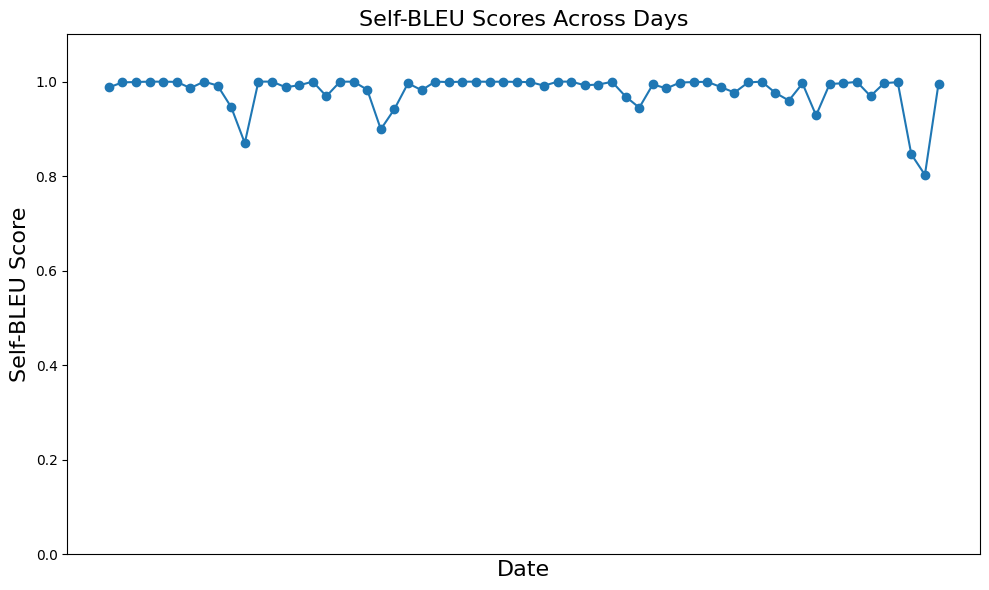

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(dates_milan, scores_milan, marker='o')
# plt.plot(dates, scores, marker='o')
plt.ylim(0, 1.1)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Self-BLEU Score', fontsize=16)
plt.title('Self-BLEU Scores Across Days', fontsize = 16)
plt.xticks([])
plt.tight_layout()
# plt.savefig('self_bleu_scores.pdf')
plt.show()

In [26]:
input_file = r"/"

print("STEP 1: Load dataset")
df = pd.read_csv("data_aruba",
                 sep='\t', header=None, names=["date","time", "sensor",
                                               "value", "activity", "log"])

df = df[~df['sensor'].str.contains("T0", na=False)]
print(len(df))

print("STEP 2: prepare dataset")
df = clean_and_prepare(df)
save_activity_dict(df,input_file)
print(df[:10])

# df['datetime'] = pd.to_datetime(df['date'], format='mixed', errors='coerce').dt.date

# df['event'] = df['sensor'] + ' ' + df['value']
# daily_events = df.groupby('date')['event'].apply(list).to_dict()

daily_events = df['activity'].groupby(df['date']).apply(list).to_dict()

def compute_self_bleu(daily_sequences):
    bleu_scores = []
    dates = list(daily_sequences.keys())
    
    for i, date in enumerate(dates):
        hypothesis = daily_sequences[date]  # Current day's sequence
        references = [daily_sequences[d] for j, d in enumerate(dates) if i != j]  # Other days as references
        
        # Compute BLEU for this day
        score = sentence_bleu(references, hypothesis)
        bleu_scores.append((date, score))
    
    return bleu_scores

bleu_results = compute_self_bleu(daily_events)

dates_aruba = [result[0] for result in bleu_results]
scores_aruba = [result[1] for result in bleu_results]

STEP 1: Load dataset
1602986
STEP 2: prepare dataset


/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_9721/2910003824.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_s.log = df_s.log.fillna(method='ffill')
/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_9721/2910003824.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_s['activity'] = df_s['activity'].fillna(method='ffill')


          date             time sensor value  activity    log
0   2010-11-04  00:03:50.209589   M003    ON  Sleeping  begin
1   2010-11-04  00:03:57.399391   M003   OFF  Sleeping  begin
15  2010-11-04  02:32:33.351906   M003    ON  Sleeping  begin
16  2010-11-04  02:32:38.895958   M003   OFF  Sleeping  begin
20  2010-11-04   03:42:21.82365   M003    ON  Sleeping  begin
22  2010-11-04   03:42:25.93973   M003   OFF  Sleeping  begin
23  2010-11-04  03:49:52.412755   M003    ON  Sleeping  begin
24  2010-11-04  03:49:57.473649   M003   OFF  Sleeping  begin
27  2010-11-04  04:14:32.835757   M003    ON  Sleeping  begin
28  2010-11-04  04:14:33.203704   M002    ON  Sleeping  begin


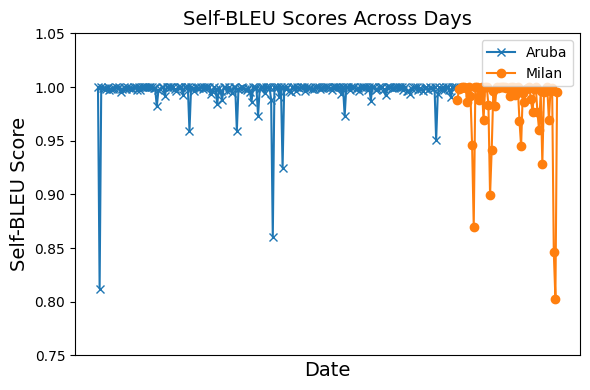

In [43]:
plt.figure(figsize=(6, 4))
# plt.plot(filtered_dates, filtered_scores, marker='o')
plt.plot(dates_aruba, scores_aruba, marker='x')
plt.plot(dates_milan, scores_milan, marker='o')
plt.ylim(0.75, 1.05)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Self-BLEU Score', fontsize=14)
plt.title('Self-BLEU Scores Across Days', fontsize = 14)
plt.xticks([])
plt.legend(['Aruba', 'Milan'])
plt.tight_layout()
plt.savefig('self_bleu.pdf')
plt.show()

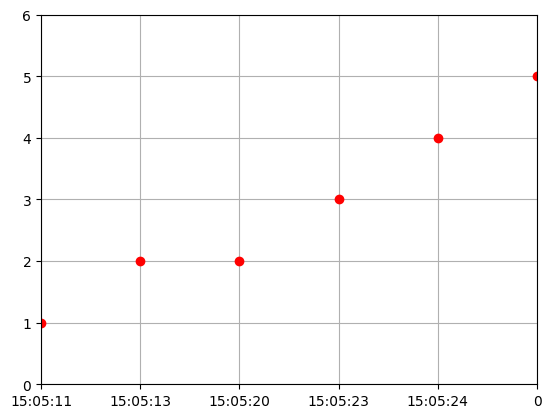

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
x = [0, 1,2,3,4,5]
y = [1,2,2,3,4,5]
plt.plot(x, y, 'ro')
plt.xlim(0, 5)
plt.ylim(0, 6)
plt.xticks(x, ('15:05:11', '15:05:13', '15:05:20', '15:05:23', '15:05:24', '0'))
plt.grid() 
plt.savefig('xticks.pdf')
plt.show()


In [2]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple/


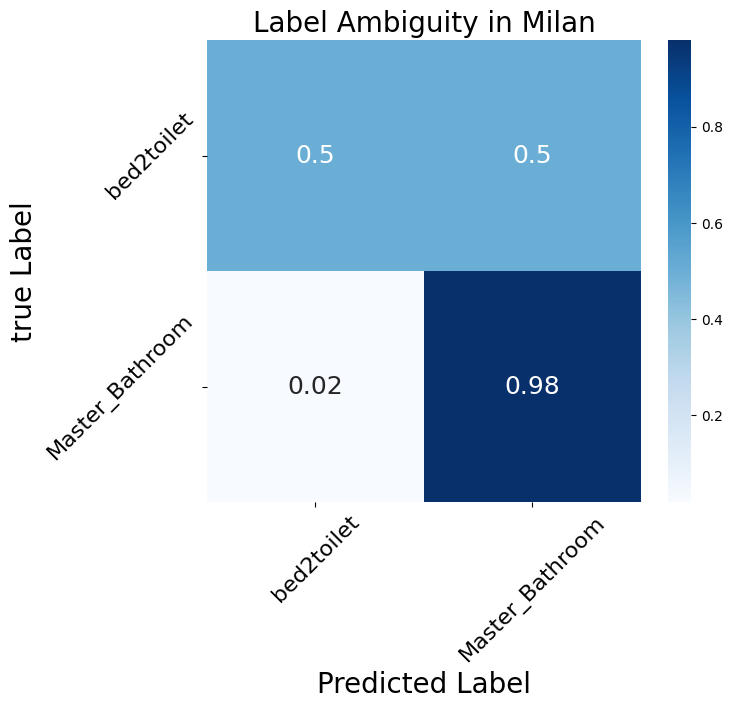

In [15]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


confusion_mat = np.array([[0.50, 0.50],
                          [0.02, 0.98]])

con_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]  # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

fig, ax = plt.subplots(figsize=(7, 6)) #14, 12
sns.heatmap(con_mat_norm, annot=True, cmap='Blues',annot_kws={'size':18},)

# ax.set(title='Confusion matrix',
#        xlabel='Predicted label',
#        ylabel='True label')

# plt.title("Ablation Without Historical Features", fontsize = 20)
plt.title("Label Ambiguity in Milan", fontsize = 20)
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('true Label', fontsize = 20)

# ax.set_xticklabels(['Other', 'Bed_to_Toilet', 'Sleep', 'Master_Bathroom', 'Morning_Meds', 'Leave_Home', 'Read', 'Kitchen_Activity', 'Desk_Activity', 'Guest_Bathroom', 'Chores', 'Meditate','Watch_TV',
#                     'Dining_Rm_Activity', 'Master_Bedroom_Activity'],rotation=45, fontsize=14)
# ax.set_yticklabels(['Other', 'Bed_to_Toilet', 'Sleep', 'Master_Bathroom', 'Morning_Meds', 'Leave_Home', 'Read', 'Kitchen_Activity', 'Desk_Activity', 'Guest_Bathroom', 'Chores', 'Meditate','Watch_TV',
#                     'Dining_Rm_Activity', 'Master_Bedroom_Activity'],rotation=45, fontsize=14)

# ax.set_xticklabels(['sleeping', 'other', 'bed2toilet', 'meal', 'realx', 'housekeeping', 'eating', 'wash_dish', 'leave',
#                     'enter', 'work', 'respirate'],rotation=45, fontsize=14)
# ax.set_yticklabels(['sleeping', 'other', 'bed2toilet', 'meal', 'realx', 'housekeeping', 'eating', 'wash_dish', 'leave',
#                     'enter', 'work', 'respirate'],rotation=45, fontsize=14)

ax.set_xticklabels(['bed2toilet','Master_Bathroom'],rotation=45, fontsize=16)
ax.set_yticklabels(['bed2toilet','Master_Bathroom'],rotation=45, fontsize=16)

# ablation
# ax.set_xticklabels(['Leave_Home','Enter_Home'],rotation=45, fontsize=16)
# ax.set_yticklabels(['Leave_Home','Enter_Home'],rotation=45, fontsize=16)

plt.savefig("milan_ambiguity.pdf", bbox_inches = 'tight')
plt.show()